# CS231a PSET 3 Problem 4: Unsupervised Monocular Depth Estimation


This the notebook you can use to complete problem 4. It's not necessary, but it may be helpful so that you don't need to install new python packges. To get going, let's get access to the data and code as in the prior problems. You can also skip this step and just upload the files directly using the files tab, though any changes you make will be gone if you close the tab or the colab runtime ends.

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# '.py' files from the p4 folder
# e.g. 'cs231a/pset3/p4'
FOLDERNAME = 'pset_3/problem4'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cd $FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/pset_3/problem4


Then, you should be able to run the following with no problem.

In [3]:
# Dataloading

import importlib

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.utils as tvutils
import torch.nn.functional as F

import problems

data = np.load('data.npz')
disparities = data['disparities']
left_images = data['left_image']
right_images = data['right_image']
left_image_t = torch.from_numpy(left_images[0])
right_image_t = torch.from_numpy(right_images[0])

## a. Horizontal flip data augmentation
Before we get started, we would like you to implement a data augmentation function for stereo images that randomly flips the given image horizontally. In neural networks, data augmentation takes a crucial role in better generalization of the problem. One of the most common data augmentation when using 2D images as input is to randomly flip the image horizontally. One interesting difference in our problem setup is that we take a pair of rectified stereo images as input. In order to maintain the stereo relationship after the horizontal flip, it requires a special attention. Please fill in the code in StereoRandomFlip to implement the data augmentation function.

Following is a visualization of a sample of input stereo images. Please fill in the function that correctly flip the stereo image for data augmentation.

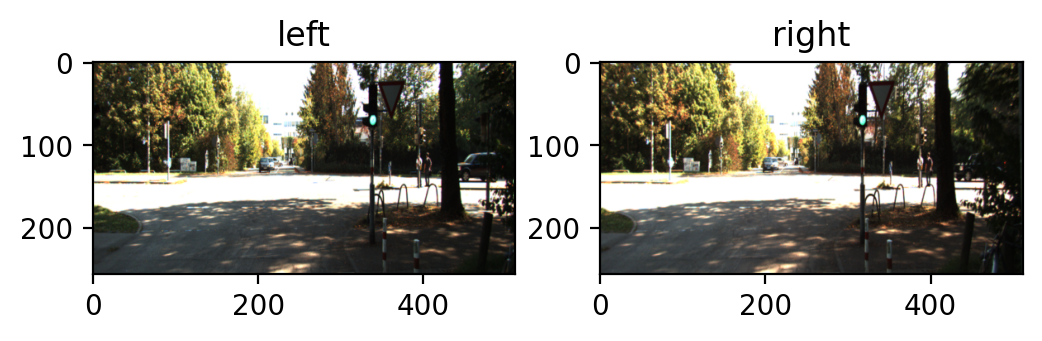

In [4]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(left_image_t, (1, 2, 0)))
ax[0].title.set_text('left')
ax[1].imshow(np.transpose(right_image_t, (1, 2, 0)))
ax[1].title.set_text('right')

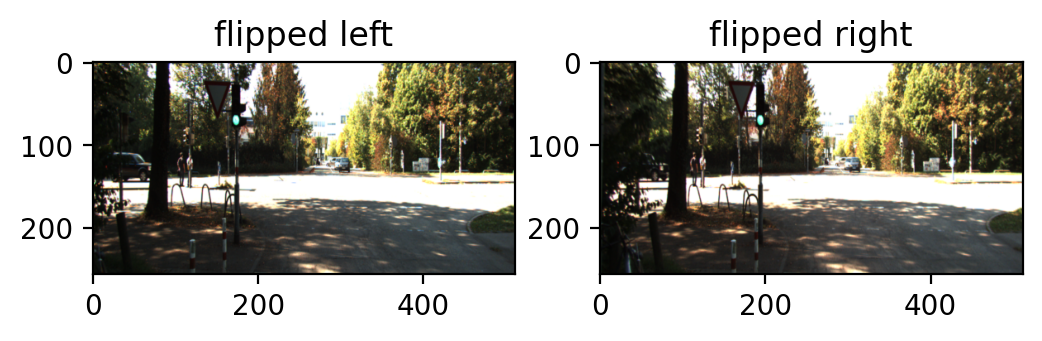

In [5]:
importlib.reload(problems)

transform_flip = problems.StereoRandomFlip()
flipped_left_t, flipped_right_t = transform_flip._flip(left_image_t, right_image_t)
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(flipped_left_t, (1, 2, 0)))
ax[0].title.set_text('flipped left')
ax[1].imshow(np.transpose(flipped_right_t, (1, 2, 0)))
ax[1].title.set_text('flipped right')

## b. Implement bilinear sampler

Next, implement a function bilinear_sampler which shifts the given horizontally given the disparity. The core idea of unsupervised monocular depth estimation is that we can generate left image from right and vice versa by sampling rectified images horizontally using the disparity. We will ask you to implement a function that simply samples image with horizontal displacement as given by the input disparity. Fill in the bilinear_sampler method at p5/problems.py

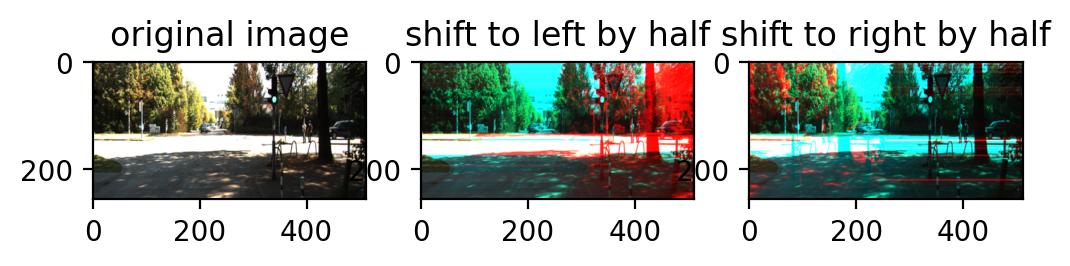

In [11]:
importlib.reload(problems)

img_left = torch.from_numpy(left_images)
img_right = torch.from_numpy(right_images)

shift_left = torch.ones_like(img_left) * 0.5
shift_right = torch.ones_like(img_left) * -0.5

img_shift_left_half = problems.bilinear_sampler(img_left, shift_left)
img_shift_right_half = problems.bilinear_sampler(img_left, shift_right)

f, ax = plt.subplots(1, 3, dpi=200)
ax[0].imshow(np.transpose(img_left[0], (1, 2, 0)))
ax[0].title.set_text('original image')
ax[1].imshow(np.transpose(img_shift_left_half[0], (1, 2, 0)))
ax[1].title.set_text('shift to left by half')
ax[2].imshow(np.transpose(img_shift_right_half[0], (1, 2, 0)))
ax[2].title.set_text('shift to right by half')

## c. Implement left/right image generator.

Finally, implement functions generate_image_right and generate_image_left which generates right view of the image from left image using the disparity and vice versa. This will be a simple one-liner that applies bilinear_sampler.

In [12]:
importlib.reload(problems)

img_left = torch.from_numpy(left_images)
img_right = torch.from_numpy(right_images)
disp_l = torch.from_numpy(disparities[0, 0]).unsqueeze(0).unsqueeze(0)
disp_r = torch.from_numpy(disparities[0, 1]).unsqueeze(0).unsqueeze(0)

img_left_est = problems.generate_image_left(img_right, disp_l)
img_right_est = problems.generate_image_right(img_left, disp_r)
disp_left_est = problems.generate_image_left(disp_r, disp_l)
disp_right_est = problems.generate_image_right(disp_l, disp_r)

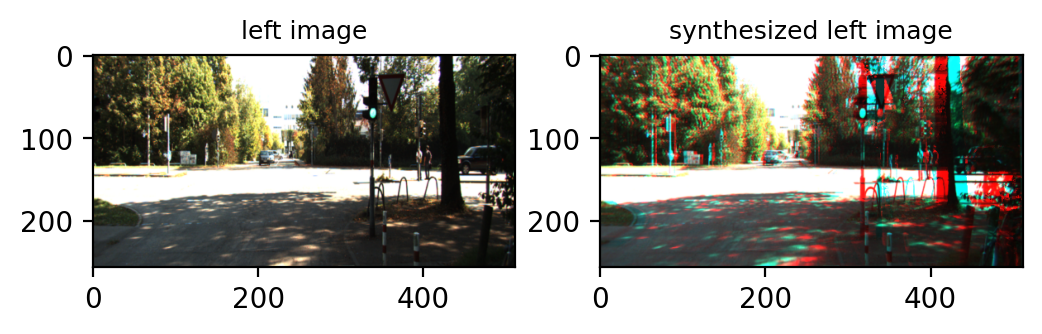

In [13]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(img_left[0], (1, 2, 0)))
ax[0].title.set_text('left image')
ax[0].title.set_fontsize(9)
ax[1].imshow(np.transpose(img_left_est[0], (1, 2, 0)))
ax[1].title.set_text('synthesized left image')
ax[1].title.set_fontsize(9)

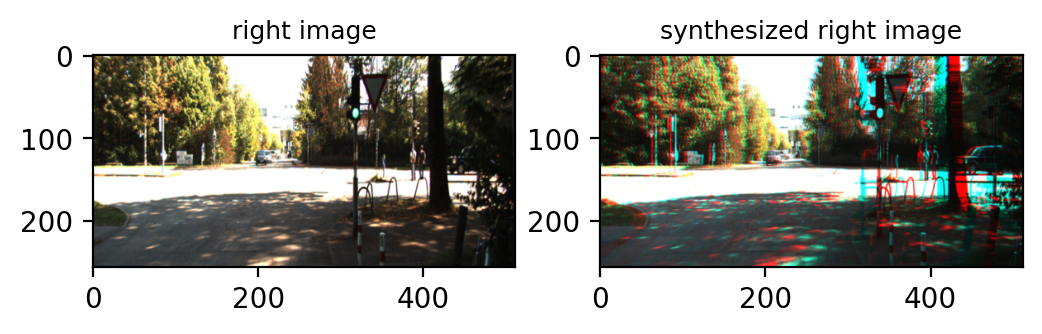

In [14]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(np.transpose(img_right[0], (1, 2, 0)))
ax[0].title.set_text('right image')
ax[0].title.set_fontsize(9)
ax[1].imshow(np.transpose(img_right_est[0], (1, 2, 0)))
ax[1].title.set_text('synthesized right image')
ax[1].title.set_fontsize(9)

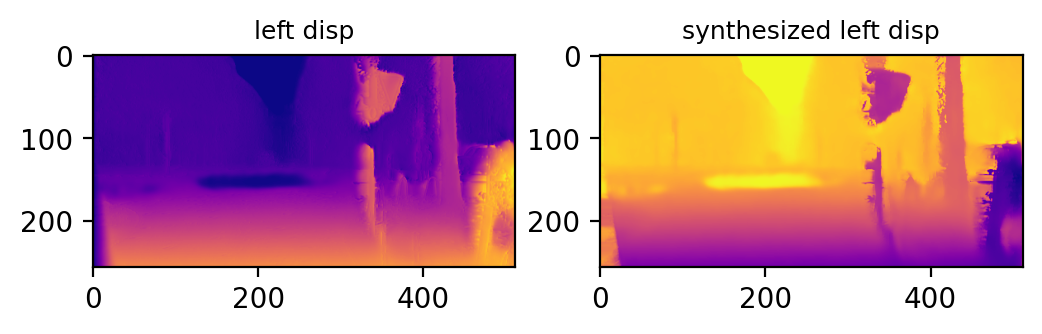

In [ ]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(disparities[0, 0], cmap='plasma')
ax[0].title.set_text('left disp')
ax[0].title.set_fontsize(9)
ax[1].imshow(disp_left_est[0, 0], cmap='plasma')
ax[1].title.set_text('synthesized left disp')
ax[1].title.set_fontsize(9)

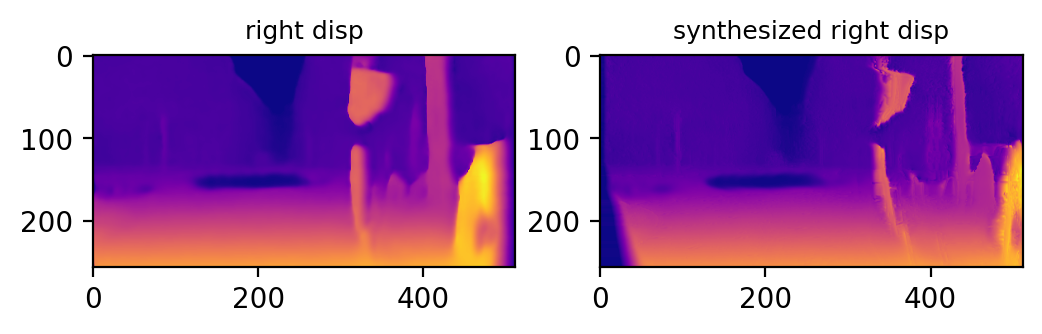

In [ ]:
f, ax = plt.subplots(1, 2, dpi=200)
ax[0].imshow(disparities[0, 1], cmap='plasma')
ax[0].title.set_text('right disp')
ax[0].title.set_fontsize(9)
ax[1].imshow(disp_right_est[0, 0], cmap='plasma')
ax[1].title.set_text('synthesized right disp')
ax[1].title.set_fontsize(9)

# Conclusion

That's it, you are done! Remember to submit your code by .py files to the autograder.